In [340]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1V3uWWt1TVMtLPiXZ6miDNXl08t1RoR-G'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Downloaded content "# -*- coding: utf-8 -*-
"""activations.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1hJUZvbNZLvldb8-gl309goyz914mlIdg
"""

import numpy as np

"""Here, a library of functions to call in neural net code"""

def relu(inp):
  return np.log(1+np.exp(inp))

def tanh(inp):
  return 0.5+ 0.5*np.tanh(inp)

def sigmoid(inp):
  return 1/(1+np.exp(-inp))

x = [1,2,3]

relu(x)"


In [0]:
#This allows drive to access the file 'activations', and subsequently get the functions in that file
functions = drive.CreateFile({'id':'1V3uWWt1TVMtLPiXZ6miDNXl08t1RoR-G'})
functions.GetContentFile('activations.py')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Mach_learn_tests/functions/')
from activations import relu, sigmoid, tanh
from itertools import islice
from random import randint
import matplotlib.pyplot as plt

First, need to create a layer class that takes many inputs, runs it through the neurons and applies an activation function.  Each neuron will be allowed to have a number of weights, stored as a (N_neurons,w_size) matrix

In [0]:
#weights have to be stored in a (N_neurons,inp.flatten().shape[0]) matrix
# I want it to perform a weight initialization upon creation of the object, then just store the weights for every subsequent call (unless updated)
#currently limited to 2-D input data, and fully connected nodes

#I want to have input that is of shape (n,d)
class layer:
  def __init__(self, inp, N_neurons, act):
    self.inp = inp#.astype(np.int64)
    self.N_neurons = N_neurons
    w_0 = self.initialize_weights()
    self.weights = w_0
    self.act = act
  def ret_input(self):
    return self.inp
  def ret_weights(self):
    return self.weights
  def process(self):
    return self.act(np.einsum('ij,lj->li',self.weights,self.inp).reshape(self.inp.shape[0],self.N_neurons))

  def initialize_weights(self):
    #Is perfomed once upon creation of a layer object, otherwise can be called to randomize weights
    #must create a matrix of weights of size equal to the input, for every neuron
    #size of (#neurons on this layer,#neurons on prev layer, 1 (for hidden/output layers) or )
    ####Must introduce bias term here, not in input data (otherwise bias is only applied for data layer, not for all layers)
    f = np.random.uniform(-0.5,0.5,self.N_neurons*self.inp.shape[1]).reshape(self.N_neurons,self.inp.shape[1]) 
    #PREV
    #f = np.random.uniform(0,1,self.N_neurons*self.inp.shape[1]*self.inp.shape[2]).reshape(self.N_neurons,self.inp.shape[1],self.inp.shape[2]) 
    return f

In [0]:
#Break data into c integer chunks. To be used for minibatching
def batches(data,labels,c=2): 
    d = np.array(np.split(data,c,axis = 0))
    l = np.array(np.split(labels,c,axis = 0))
    return d, l

In [0]:
def backprop(D,L,args,epochs=50,learn_rate=0.1,reg_rate=0.01):
    args = args[::-1]#list(reversed(args))
    #Alter this code to do an update for each sample, rather than update for average.  Update for average causes classification of all datapoints to be the same
    #applies weight updates in reverse, ie backprop
    for i in range(epochs):
      for j in range(data.shape[0]):
        data_chunk = D[j]
        labels_chunk = L[j]
        arg_num =0
        delt = []
        for arg in args:
          #d shape: (#datapoints,#neurons at this layer)
          if arg.act == relu:
            c = arg.process()/(1+arg.process())
          elif arg.act == tanh:
            c = 0.25*(1-4*(arg.process()-0.5)*(arg.process()-0.5))
          elif arg.act == sigmoid: 
            c = arg.process()*(1-arg.process())
          #for output, compare to target
          if arg ==args[0]:
            d = (arg.process()-labels_chunk.reshape(labels_chunk.shape[0],1))
          #for input and hidden nodes
          else:
            d = np.einsum('ji,lj->li',args[arg_num-1].weights,delt[arg_num-1])

          delt.append(d*c)

          #for input nodes
          if arg ==args[-1]:
              #This line makes a datapoint-averaged change to weights 
              arg.weights = arg.ret_weights() - learn_rate*(np.mean(np.matmul(delt[arg_num][:,:,np.newaxis],data_chunk[:,np.newaxis,:]),axis = 0) + 2*reg_rate*arg.ret_weights())
          #for hidden and output nodes
          else:
              arg.weights = arg.ret_weights() - learn_rate*(np.mean(np.matmul(delt[arg_num][:,:,np.newaxis],args[arg_num+1].process()[:,np.newaxis,:]),axis = 0) + 2*reg_rate*arg.ret_weights())
          arg_num +=1
    #print('Final loss:', 0.5*np.mean(np.power(args[0].process()-labels_chunk,2)))
    return args[::-1]

In [0]:
def generator_complex(number_examples,number_dimensions=2):
    data = np.random.uniform(low=0, high=1, size=(number_examples,number_dimensions))
    labels = np.zeros(number_examples)
    for i in range(number_examples):
        if (data[i,0]<=0.5) & (data[i,1]<=0.5):
          labels[i] = 0
        else:
          labels[i] = 1
        labels = labels.astype(int)
    return data,labels

In [0]:
def comp(data, num_neurons, act):
  print('Data shape: ',(data.shape))
  print('           # Nodes  # weights')
  i = 0
  L_vec = []
  for i in range(len(num_neurons)):
    if i==0:
      L = layer(data[0],num_neurons[i],act[i])
      print('Layer {}:     {}         {}'.format(i+1,L.process().shape[1],np.prod(L.weights.shape)))
    else:
      L = layer(L_vec[i-1].process(),num_neurons[i],act[i])
      print('Layer {}:     {}         {}'.format(i+1,L.process().shape[1],np.prod(L.weights.shape)))
    L_vec.append(L) 
  return L_vec
  

In [0]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(train_data,train_labels),(test_data,test_labels) = mnist.load_data()

# Flatten the train_data and test_data for faster computation.
train_data = train_data.flatten().reshape(60000,784)
test_data = test_data.flatten().reshape(10000,784)

# If the datatype of the above arrays is int8, convert them to float/int 32/64.
train_data = np.array(train_data,dtype= 'float32')/255
test_data = np.array(test_data,dtype= 'float32')/255

Data shape:  (10, 2, 5)
           # Nodes  # weights
Layer 1:     6         30
Layer 2:     5         30
Layer 3:     1         5
[[0.69831478 1.        ]
 [0.69931839 1.        ]]
0.75


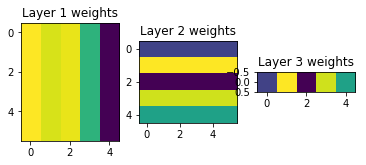

In [349]:
#data = train_data[0:100,:]
#labels = train_labels[0:100]/10
#data1 = -np.ones((100,1))
#np.hstack((data,data1))
#data,labels = batches(data,labels,5)

data,labels = generator_complex(20,4)
data = data.reshape(20,4)
data1 = -np.ones((20,1))
data = np.hstack((data,data1))
data,labels = batches(data,labels,10)
#labels = np.random.rand(10,1)

Layers = comp(data,[6,5,1],[sigmoid,relu,sigmoid])
net = backprop(data,labels,Layers,epochs=100,learn_rate=2,reg_rate=0.01)

fig, (*args) = plt.subplots(1,len(Layers))
for i in range(len(Layers)):
  args[0][i].set_title('Layer {} weights'.format(i+1))
  args[0][i].imshow(net[i].weights)

print(np.stack((net[-1].process()[0:10].flatten(), labels[0,0:10].flatten()),axis = 1))
print(np.mean(labels))

In [350]:
data.shape

(10, 2, 5)

In [351]:
net[1].weights

array([[0.07053359, 0.07053359, 0.07053359, 0.07053359, 0.07053359,
        0.07053359],
       [0.07053359, 0.07053359, 0.07053359, 0.07053359, 0.07053359,
        0.07053359],
       [0.07053359, 0.07053359, 0.07053359, 0.07053359, 0.07053359,
        0.07053359],
       [0.07053359, 0.07053359, 0.07053359, 0.07053359, 0.07053359,
        0.07053359],
       [0.07053359, 0.07053359, 0.07053359, 0.07053359, 0.07053359,
        0.07053359]])